# Extraction of AOD-Derived PM2.5 Grids via BYOC Collection

In [1]:
import os

# define repo name and get root working directory
repo = 'byoc-api'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\byoc-api'

### _Setup imports and configuration_

In [2]:
from sentinelhub import (
    SHConfig, DataCollection, Geometry, BBox, CRS,
    SentinelHubRequest, filter_times, bbox_to_dimensions, MimeType,
    SentinelHubBYOC, ByocCollection, ByocTile, ByocCollectionAdditionalData,
    DownloadFailedException
)

# Initialize SentinelHubBYOC class
config = SHConfig()

In [3]:
# get pathname to configuration file
cfg_path = os.path.join( os.path.join( root_path, 'cfg/sedac' ) )
cfg_file = os.path.join( cfg_path, 'pm25.yml' )
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [{
                            bands: ["pm25" ],
                        } ],
                        output: { 
                            bands: 1, sampleType: SampleType.FLOAT32
                        }
                    }
                }
                function evaluatePixel(samples) {                  
                    return [ samples.pm25 ]
                }
    inputs:
        - collection: byoc-1f536de6-b8b2-42ca-9146-7c1c04b68a1a        
responses:
    default: TIFF



In [4]:
import yaml
from munch import munchify

# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

### _Define Area of Interest covering southern UK_

In [5]:
# setup aoi limits and resolution
coords = -5, 51, -1, 53
resolution = 1000

In [6]:
# create instance of shclient class
from processapi import Client
client = Client( config )

In [7]:
# get utm bbox
bbox = client.getBoundingBox( coords, src_crs=CRS(4326) )
print ( bbox, bbox.crs.value )

359666.7036616802,5651728.68267166,634213.2490738616,5874141.630656594 32630


In [8]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(275, 222)

### _Pick timeframe encompassing BYOC time series_

In [9]:
# pick a few dates
from datetime import datetime
timeframe = { 'start' : datetime( 2010, 9, 1, 0, 0, 0 ), 
                'end' : datetime( 2012, 11, 7, 23, 59, 59 ) }
timeframe

{'start': datetime.datetime(2010, 9, 1, 0, 0),
 'end': datetime.datetime(2012, 11, 7, 23, 59, 59)}

In [10]:
# get S1 acquisitions between start / end dates satisfying filter conditions
client.getDatasetTimeStamps( config.request.inputs[ 0 ], bbox, timeframe )

[datetime.datetime(2011, 1, 1, 0, 0, tzinfo=tzutc())]

### _Get BYOC extract fused with spatially and temporally collocated Sentinel-2 imagery_

In [11]:
# get time series
response = client.getTimeSeries ( bbox, timeframe, resolution )
response._df

,default,time
0,"[[-3.4028235e+38, -3.4028235e+38, -3.4028235e+...",2011-01-01 00:00:00+00:00


In [20]:
import numpy as np

np.max( response._df.loc[ 0 ][ 0 ] )

15.5

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


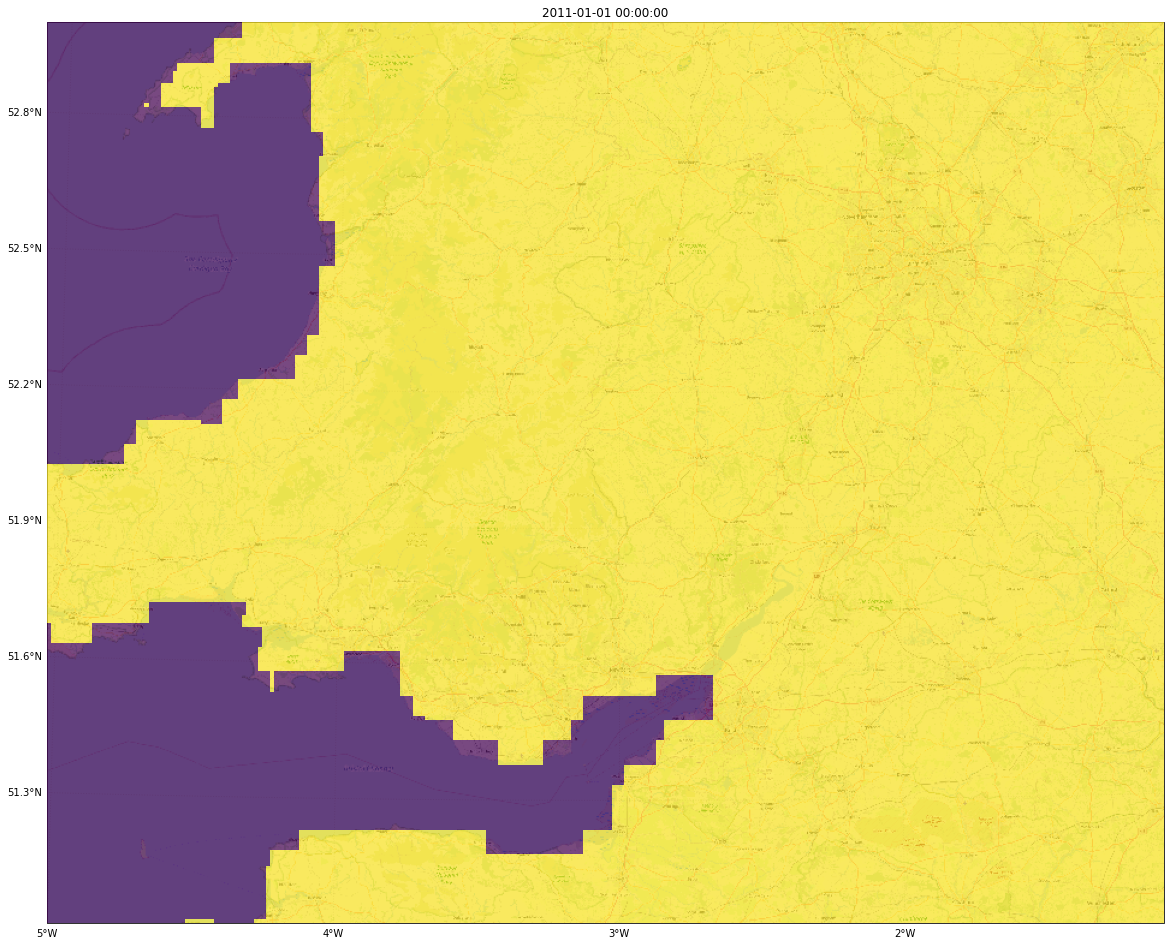

In [13]:
response.plotImages( 'default', osm_zoom=10, alpha={ 'data' : 0.7, 'grid' : 0.3 } )